In [12]:
import time
import os
import random
import math

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, models, transforms
from PIL import Image

import progressbar

from __future__ import division

plt.ion()   # interactive mode

In [13]:
### Some utilities

In [14]:
def to_2d_tensor(inp):
    inp = torch.Tensor(inp)
    if len(inp.size()) < 2:
        inp = inp.unsqueeze(0)
    return inp

def xywh_to_x1y1x2y2(boxes):
    boxes = to_2d_tensor(boxes)
    boxes[:, 2] += boxes[:, 0] - 1
    boxes[:, 3] += boxes[:, 1] - 1
    return boxes

def x1y1x2y2_to_xywh(boxes):
    boxes = to_2d_tensor(boxes)
    boxes[:, 2] -= boxes[:, 0] - 1
    boxes[:, 3] -= boxes[:, 1] - 1
    return boxes

def crop_boxes(boxes, im_sizes):
    boxes = to_2d_tensor(boxes)
    im_sizes = to_2d_tensor(im_sizes)
    boxes = xywh_to_x1y1x2y2(boxes)
    zero = torch.Tensor([0])
    boxes[:, 0] = torch.max(torch.min(boxes[:, 0], im_sizes[:, 0]), zero)
    boxes[:, 1] = torch.max(torch.min(boxes[:, 1], im_sizes[:, 1]), zero)
    boxes[:, 2] = torch.max(torch.min(boxes[:, 2], im_sizes[:, 0]), zero)
    boxes[:, 3] = torch.max(torch.min(boxes[:, 3], im_sizes[:, 1]), zero)
    boxes = x1y1x2y2_to_xywh(boxes)
    return boxes

def box_transform(boxes, im_sizes):
    # box in (x, y, w, h) format
    boxes = to_2d_tensor(boxes)
    im_sizes = to_2d_tensor(im_sizes)
    boxes[:, 0] = 2 * boxes[:, 0] / im_sizes[:, 0] - 1
    boxes[:, 1] = 2 * boxes[:, 1] / im_sizes[:, 1] - 1
    boxes[:, 2] = 2 * boxes[:, 2] / im_sizes[:, 0]
    boxes[:, 3] = 2 * boxes[:, 3] / im_sizes[:, 1]
    return boxes

def box_transform_inv(boxes, im_sizes):
    # box in (x, y, w, h) format
    boxes = to_2d_tensor(boxes)
    im_sizes = to_2d_tensor(im_sizes)
    boxes[:, 0] = (boxes[:, 0] + 1) / 2 * im_sizes[:, 0]
    boxes[:, 1] = (boxes[:, 1] + 1) / 2 * im_sizes[:, 1]
    boxes[:, 2] = boxes[:, 2] / 2 * im_sizes[:, 0]
    boxes[:, 3] = boxes[:, 3] / 2 * im_sizes[:, 1]
    return boxes

def compute_IoU(boxes1, boxes2):
    boxes1 = to_2d_tensor(boxes1)
    boxes1 = xywh_to_x1y1x2y2(boxes1)
    boxes2 = to_2d_tensor(boxes2)
    boxes2 = xywh_to_x1y1x2y2(boxes2)
    
    intersec = boxes1.clone()
    intersec[:, 0] = torch.max(boxes1[:, 0], boxes2[:, 0])
    intersec[:, 1] = torch.max(boxes1[:, 1], boxes2[:, 1])
    intersec[:, 2] = torch.min(boxes1[:, 2], boxes2[:, 2])
    intersec[:, 3] = torch.min(boxes1[:, 3], boxes2[:, 3])
    
    def compute_area(boxes):
        # in (x1, y1, x2, y2) format
        dx = boxes[:, 2] - boxes[:, 0]
        dx[dx < 0] = 0
        dy = boxes[:, 3] - boxes[:, 1]
        dy[dy < 0] = 0
        return dx * dy
    
    a1 = compute_area(boxes1)
    a2 = compute_area(boxes2)
    ia = compute_area(intersec)
    assert((a1 + a2 - ia <= 0).sum() == 0)
    
    return ia / (a1 + a2 - ia)    

def compute_acc(preds, targets, im_sizes, theta=0.75):
    preds = box_transform_inv(preds.clone(), im_sizes)
    preds = crop_boxes(preds, im_sizes)
    targets = box_transform_inv(targets.clone(), im_sizes)
    IoU = compute_IoU(preds, targets)
    corr = (IoU >= theta).sum()
    return corr.item() / preds.size(0)

class AverageMeter(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.cnt = 0
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt
        

### Split dataset

In [15]:
def split(ratio):
    with open('data/images.txt') as f:
        lines = f.read().splitlines()
    class_groups = dict()
    for line in lines:
        value, line = line.split(' ', 1)
        key = line.split('.', 1)[0]
        value = value
        if key in class_groups:
            class_groups[key].append(value)
        else:
            class_groups[key] = [value]
            
    test_id = []
    for _, group in class_groups.items():
        test_id.extend(random.sample(group, int(math.ceil(len(group)*ratio))))
    train_id = [i for i in map(str, range(1, len(lines)+1)) if i not in test_id]
    
    return train_id, test_id

train_id, test_id = split(0.2)

In [16]:
class CUBDataset(Dataset):
    def __init__(self, im_ids, transform=None):
        with open('data/images.txt') as f:
            id_to_path = dict([l.split(' ', 1) for l in f.read().splitlines()])
        with open('data/bounding_boxes.txt') as f:
            id_to_box = dict()
            for line in f.read().splitlines():
                im_id, *box = line.split(' ')
                id_to_box[im_id] = list(map(float, box))
        self.imgs = [(os.path.join('data/images', id_to_path[i]), id_to_box[i])
                     for i in im_ids]
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transform
            
    def __getitem__(self, index):
        path, box = self.imgs[index]
        im = Image.open(path).convert('RGB')
        im_size = np.array(im.size, dtype='float32')
        box = np.array(box, dtype='float32')
        
        im = self.transform(im)
        
        return im, box, im_size
    
    def __len__(self):
        return len(self.imgs)
    

In [17]:
### Define Dataset

In [18]:
splits = {'train': train_id, 'test': test_id}
datasets = {split: CUBDataset(splits[split]) for split in ('train', 'test')}

### Visualize training data

In [19]:
def imshow(img, gt_box, pred_box=None):
    plt.imshow(img)
    
    def draw_box(box, color='green'):
        x, y, w, h = box_transform_inv(box, img.shape[:2][::-1])[0]
        if x == 0:
            x = 1
        if y == 0:
            y = 1
        plt.gca().add_patch(
            plt.Rectangle((x, y), w, h,
                          fill=False, edgecolor=color, linewidth=2, alpha=0.5)
        )
        
    draw_box(gt_box)
    if pred_box is not None:
        draw_box(pred_box, 'red')

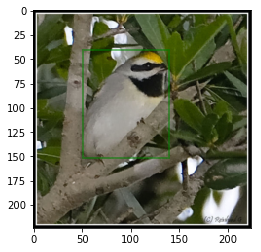

In [20]:
ind = random.choice(range(len(datasets['train'])))
im, box, im_size = datasets['train'][ind]
box = box_transform(box, im_size)

inp = im.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inp = std * inp + mean
inp = np.clip(inp, 0, 1)

imshow(inp, box[0])

### Training

In [ ]:
# prepare data
dataloaders = {split: torch.utils.data.DataLoader(
                datasets[split], batch_size=32,shuffle=(split=='train'),
                num_workers=2, pin_memory=True) for split in ('train', 'test')}

# construct model
model = models.resnet18(pretrained=True)
fc_in_size = model.fc.in_features
model.fc = nn.Linear(fc_in_size, 4)
model = model.cuda()
criterion = nn.SmoothL1Loss().cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

best_model_state = model.state_dict()
best_epoch = -1
best_acc = 0.0

epoch_loss = {'train': [], 'test': []}
epoch_acc = {'train': [], 'test': []}
epochs = 20
for epoch in range(20):
    accs = AverageMeter()
    losses = AverageMeter()
    for phase in ('train', 'test'):
        if phase == 'train':
            scheduler.step()
            model.train(True)
        else:
            model.train(False)
            
        end = time.time()
        bar = progressbar.ProgressBar()
        for ims, boxes, im_sizes in bar(dataloaders[phase]):
            boxes = crop_boxes(boxes, im_sizes)
            boxes = box_transform(boxes, im_sizes)
            
            inputs = Variable(ims.cuda())
            targets = Variable(boxes.cuda())
            
            optimizer.zero_grad()
            
            # forward
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            acc = compute_acc(outputs.data.cpu(), targets.data.cpu(), im_sizes)
            
            nsample = inputs.size(0)
            accs.update(acc, nsample)
            losses.update(loss.data[0], nsample)
            
            if phase == 'train':
                loss.backward()
                optimizer.step()
        
        if phase == 'test' and accs.avg > best_acc:
            best_acc = accs.avg
            best_epoch = epoch
            best_model_state = model.state_dict()
            
        elapsed_time = time.time() - end
        print('[{}]\tEpoch: {}/{}\tLoss: {:.4f}\tAcc: {:.2%}\tTime: {:.3f}'.format(
            phase, epoch+1, epochs, losses.avg, accs.avg, elapsed_time))
        epoch_loss[phase].append(losses.avg)
        epoch_acc[phase].append(accs.avg)
        
    print('[Info] best test acc: {:.2%} at {}th epoch'.format(best_acc, best_epoch))
    torch.save(best_model_state, 'best_model_state.path.tar')

N/A% (0 of 295) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--/home/ubuntu/anaconda3/envs/ai_3_2/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
100% (295 of 295) |######################| Elapsed Time: 0:01:17 Time:  0:01:17


[train]	Epoch: 1/20	Loss: 0.0266	Acc: 24.81%	Time: 78.324


100% (75 of 75) |########################| Elapsed Time: 0:00:11 Time:  0:00:11


[test]	Epoch: 1/20	Loss: 0.0233	Acc: 29.53%	Time: 11.691
[Info] best test acc: 29.53% at 0th epoch


100% (295 of 295) |######################| Elapsed Time: 0:01:18 Time:  0:01:18


[train]	Epoch: 2/20	Loss: 0.0110	Acc: 40.33%	Time: 78.663


100% (75 of 75) |########################| Elapsed Time: 0:00:11 Time:  0:00:11


[test]	Epoch: 2/20	Loss: 0.0113	Acc: 37.67%	Time: 11.459
[Info] best test acc: 37.67% at 1th epoch


100% (295 of 295) |######################| Elapsed Time: 0:01:18 Time:  0:01:18


[train]	Epoch: 3/20	Loss: 0.0080	Acc: 48.92%	Time: 78.759


100% (75 of 75) |########################| Elapsed Time: 0:00:11 Time:  0:00:11


[test]	Epoch: 3/20	Loss: 0.0078	Acc: 52.43%	Time: 11.353
[Info] best test acc: 52.43% at 2th epoch


100% (295 of 295) |######################| Elapsed Time: 0:01:18 Time:  0:01:18


[train]	Epoch: 4/20	Loss: 0.0053	Acc: 63.70%	Time: 78.863


100% (75 of 75) |########################| Elapsed Time: 0:00:11 Time:  0:00:11


[test]	Epoch: 4/20	Loss: 0.0070	Acc: 57.50%	Time: 11.732
[Info] best test acc: 57.50% at 3th epoch


100% (295 of 295) |######################| Elapsed Time: 0:01:18 Time:  0:01:18


[train]	Epoch: 5/20	Loss: 0.0048	Acc: 65.62%	Time: 78.820


100% (75 of 75) |########################| Elapsed Time: 0:00:11 Time:  0:00:11


[test]	Epoch: 5/20	Loss: 0.0053	Acc: 66.55%	Time: 11.650
[Info] best test acc: 66.55% at 4th epoch


100% (295 of 295) |######################| Elapsed Time: 0:01:18 Time:  0:01:18


[train]	Epoch: 6/20	Loss: 0.0020	Acc: 90.76%	Time: 78.817


100% (75 of 75) |########################| Elapsed Time: 0:00:11 Time:  0:00:11


[test]	Epoch: 6/20	Loss: 0.0024	Acc: 89.67%	Time: 11.846
[Info] best test acc: 89.67% at 5th epoch


100% (295 of 295) |######################| Elapsed Time: 0:01:18 Time:  0:01:18


[train]	Epoch: 7/20	Loss: 0.0015	Acc: 93.00%	Time: 78.786


100% (75 of 75) |########################| Elapsed Time: 0:00:11 Time:  0:00:11


[test]	Epoch: 7/20	Loss: 0.0020	Acc: 91.61%	Time: 12.358
[Info] best test acc: 91.61% at 6th epoch


100% (295 of 295) |######################| Elapsed Time: 0:01:18 Time:  0:01:18


[train]	Epoch: 8/20	Loss: 0.0014	Acc: 94.10%	Time: 78.955


100% (75 of 75) |########################| Elapsed Time: 0:00:11 Time:  0:00:11


[test]	Epoch: 8/20	Loss: 0.0019	Acc: 92.54%	Time: 11.633
[Info] best test acc: 92.54% at 7th epoch


100% (295 of 295) |######################| Elapsed Time: 0:01:18 Time:  0:01:18


[train]	Epoch: 9/20	Loss: 0.0012	Acc: 94.88%	Time: 78.962


100% (75 of 75) |########################| Elapsed Time: 0:00:10 Time:  0:00:10


[test]	Epoch: 9/20	Loss: 0.0017	Acc: 93.07%	Time: 11.081
[Info] best test acc: 93.07% at 8th epoch


100% (295 of 295) |######################| Elapsed Time: 0:01:18 Time:  0:01:18


[train]	Epoch: 10/20	Loss: 0.0011	Acc: 95.93%	Time: 78.825


100% (75 of 75) |########################| Elapsed Time: 0:00:11 Time:  0:00:11


[test]	Epoch: 10/20	Loss: 0.0016	Acc: 94.10%	Time: 11.683
[Info] best test acc: 94.10% at 9th epoch


 77% (228 of 295) |#################     | Elapsed Time: 0:01:00 ETA:   0:00:17

In [ ]:
plt.figure(figsize=(15,10))
for phase in ('train', 'test'):
    plt.plot(range(len(epoch_loss[phase])), epoch_loss[phase], label=(phase + '_loss'))
    plt.plot(range(len(epoch_acc[phase])), epoch_acc[phase], label=(phase + '_acc'))
plt.legend(prop={'size': 15})

### Visualize predicting result

In [ ]:
model.load_state_dict(best_model_state)
model = model.cpu()

In [ ]:
ind = random.choice(range(len(datasets['test'])))
im, box, im_size = datasets['test'][ind]
path, _ = datasets['test'].imgs[ind]
print(box)
print(im_size)
box = box_transform(box, im_size)[0]
#print(im_size)
#print(box)


pred_box = model(Variable(im.unsqueeze(0))).data[0]

ori_im = np.array(Image.open(path))

inp = im.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inp = std * inp + mean
inp = np.clip(inp, 0, 1)

imshow(ori_im, box, pred_box)